<a href="https://colab.research.google.com/github/Maxibrionest/MachineLearning/blob/main/Entrega2/Entrega2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning, caso de estudio Monopoly/Dormammu**

Nombre: Maximiliano Briones / Lucas Vásquez

Sección: 003V

Evaluación: 2

Fecha de entrega: 19/11/2021

---


## **Fase I. Business Understanding**

El banco "Monopoly" fue adquirido recientemente por el banco, con capitales extranjeros, "Dormammu". Éste encargó hacer estudios sobre la adquisición, determinando  comportamiento, patrones y una estrategia para abordar a los nuevos clientes.

La base de datos que se extrajo corresponde a una muestra de 12 meses con información de clientes, en variables mensuales para cada uno.

[Link a enunciado original](https://github.com/Maxibrionest/MachineLearning/blob/main/Entrega1/ET221_3A_MLY0100.docx).

En base a lo anterior, se determinó como target el monto de pagos de deuda internacional del cliente en el mes 12.



In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
sheetname = 'Transición de Negocio'
path_to_file = '/gdrive/MyDrive/DUOC/2021 - 2/MLY/Entrega2/Base_clientes_Monopoly.xlsx'
df = pd.read_excel(path_to_file, sheet_name=sheetname, header=1)

# Sección nueva

Al ver el excel, existe una suma que da cuenta de la cantidad de columnas y que está en la misma altura que los headers de las columnas, por lo que se eliminará al no aportar valor.

In [4]:
df.columns

Index(['Id', 'Subsegmento', 'Sexo', 'Region', 'Edad', 'Renta', 'Antiguedad',
       'Internauta', 'Adicional', 'Dualidad',
       ...
       'PagoNac_T01', 'PagoInt_T01', 'EeccNac_T01', 'EeccInt_T01', 'UsoL1_T01',
       'UsoL2_T01', 'UsoLI_T01', 'IndRev_T01', 'target', 'Unnamed: 574'],
      dtype='object', length=575)

In [5]:
df = df.drop(columns=['Unnamed: 574'])

In [6]:
print("Cantidad de observaciones: ", df.shape[0])
print("Cantidad de columnas:      ", df.shape[1])
print("Cantidad de datos:         ", df.shape[0] * df.shape[1])
observaciones = df.shape[0]

Cantidad de observaciones:  51124
Cantidad de columnas:       574
Cantidad de datos:          29345176


In [7]:
corrdat = df.corr()

In [8]:
def getCorr(dat, lim): #obtiene los features con mayor impacto en el target
    feature = []
    valor = []
    
    for i , index in enumerate(dat.index): #bucle para todos los indices
        if abs(dat[index]) > lim:
            feature.append(index)
            print(index)
            valor.append(dat[index])

    df = pd.DataFrame(data = valor, index = feature, columns = ['corr value'])

    return df

In [9]:
lim = 0.01
corr_value = getCorr(corrdat['PagoInt_T12'], lim)

Hipotecario
CUPO_L1
CUPO_MX
FacCI_T12
PagoInt_T12
FlgActCCOT_T11
PagoInt_T07


In [10]:
corrdat['PagoInt_T12'].sort_values(key=abs, ascending=False)

PagoInt_T12       1.000000
CUPO_L1           0.017535
FlgActCCOT_T11    0.013894
FacCI_T12         0.012834
Hipotecario       0.011549
                    ...   
ColL1T0_T03      -0.000029
ColL2CC_T07      -0.000024
TxsDebAtm_T02     0.000018
TxsDebAtm_T07     0.000009
CambioPin              NaN
Name: PagoInt_T12, Length: 561, dtype: float64

#### Region
Región de residencia del cliente. Rango de valores de 1 a 13 inclusivos, por lo que se asume que no está aplicada la división de 2018, tomando en cuenta 13 regiones con la metropolitana como número 13.

In [11]:
print("Cantidad de MV en variable: ", df['Region'].isnull().sum())
print(f"Porcentaje de MV: {round(df['Region'].isnull().sum()/observaciones*100,3)}%")

Cantidad de MV en variable:  53
Porcentaje de MV: 0.104%


Buscamos un sistema que modele segun los datos del mes anterior (POR AHORA)

In [12]:
df.columns

Index(['Id', 'Subsegmento', 'Sexo', 'Region', 'Edad', 'Renta', 'Antiguedad',
       'Internauta', 'Adicional', 'Dualidad',
       ...
       'ColMx_T01', 'PagoNac_T01', 'PagoInt_T01', 'EeccNac_T01', 'EeccInt_T01',
       'UsoL1_T01', 'UsoL2_T01', 'UsoLI_T01', 'IndRev_T01', 'target'],
      dtype='object', length=574)

In [13]:
lim = 0.55
corr_value = getCorr(corrdat['target'], lim)

target


In [14]:
corrdat['PagoInt_T12'].sort_values(key=abs, ascending=False)

PagoInt_T12       1.000000
CUPO_L1           0.017535
FlgActCCOT_T11    0.013894
FacCI_T12         0.012834
Hipotecario       0.011549
                    ...   
ColL1T0_T03      -0.000029
ColL2CC_T07      -0.000024
TxsDebAtm_T02     0.000018
TxsDebAtm_T07     0.000009
CambioPin              NaN
Name: PagoInt_T12, Length: 561, dtype: float64

In [15]:
cols_flag = []
for i in df.columns:
  if i[0:3] == "Flg":
    cols_flag.append(i)


In [16]:
print(cols_flag)
print(len(cols_flag))

['FlgAct_T12', 'FlgActCN_T12', 'FlgActCI_T12', 'FlgActAN_T12', 'FlgActAI_T12', 'FlgActPAT_T12', 'FlgActCCPC_T12', 'FlgActCCOT_T12', 'FlgActCOL_T12', 'FlgAct_T11', 'FlgActCN_T11', 'FlgActCI_T11', 'FlgActAN_T11', 'FlgActAI_T11', 'FlgActPAT_T11', 'FlgActCCPC_T11', 'FlgActCCOT_T11', 'FlgActCOL_T11', 'FlgAct_T10', 'FlgActCN_T10', 'FlgActCI_T10', 'FlgActAN_T10', 'FlgActAI_T10', 'FlgActPAT_T10', 'FlgActCCPC_T10', 'FlgActCCOT_T10', 'FlgActCOL_T10', 'FlgAct_T09', 'FlgActCN_T09', 'FlgActCI_T09', 'FlgActAN_T09', 'FlgActAI_T09', 'FlgActPAT_T09', 'FlgActCCPC_T09', 'FlgActCCOT_T09', 'FlgActCOL_T09', 'FlgAct_T08', 'FlgActCN_T08', 'FlgActCI_T08', 'FlgActAN_T08', 'FlgActAI_T08', 'FlgActPAT_T08', 'FlgActCCPC_T08', 'FlgActCCOT_T08', 'FlgActCOL_T08', 'FlgAct_T07', 'FlgActCN_T07', 'FlgActCI_T07', 'FlgActAN_T07', 'FlgActAI_T07', 'FlgActPAT_T07', 'FlgActCCPC_T07', 'FlgActCCOT_T07', 'FlgActCOL_T07', 'FlgAct_T06', 'FlgActCN_T06', 'FlgActCI_T06', 'FlgActAN_T06', 'FlgActAI_T06', 'FlgActPAT_T06', 'FlgActCCPC_T06'

In [17]:
def buscar_cols(texto, numero):
  columnas = []
  for i in df.columns:
    columnas.append(i)
  col = []
  for i in columnas:
    if i[0:numero] == texto:
      col.append(i)
  return col

In [18]:
col_Txs_T = buscar_cols("Txs_T", 5)
print(col_Txs_T)

['Txs_T12', 'Txs_T11', 'Txs_T10', 'Txs_T09', 'Txs_T08', 'Txs_T07', 'Txs_T06', 'Txs_T05', 'Txs_T04', 'Txs_T03', 'Txs_T02', 'Txs_T01']


In [19]:
def buscar_t12():
    cols_a_dropear = []
    for i in df.columns:
        if i[-3:] == "T12":
            cols_a_dropear.append(i)
    return cols_a_dropear

In [20]:
cols_drop_1 = buscar_t12()
cols_drop_1

['FlgAct_T12',
 'FlgActCN_T12',
 'FlgActCI_T12',
 'FlgActAN_T12',
 'FlgActAI_T12',
 'FlgActPAT_T12',
 'FlgActCCPC_T12',
 'FlgActCCOT_T12',
 'FlgActCOL_T12',
 'Fac_T12',
 'Txs_T12',
 'FacCN_T12',
 'TxsCN_T12',
 'FacCI_T12',
 'TxsCI_T12',
 'FacAN_T12',
 'TxsAN_T12',
 'FacAI_T12',
 'TxsAI_T12',
 'FacPAT_T12',
 'TxsPAT_T12',
 'FacCCPC_T12',
 'TxsCCPC_T12',
 'FacCCOT_T12',
 'TxsCCOT_T12',
 'FacCOL_T12',
 'TxsCOL_T12',
 'FacDebCom_T12',
 'TxsDebCom_T12',
 'FacDebAtm_T12',
 'TxsDebAtm_T12',
 'Col_T12',
 'ColL1T0_T12',
 'ColL1TE_T12',
 'ColL2T0_T12',
 'ColL2AC_T12',
 'ColL2CC_T12',
 'ColMx_T12',
 'PagoNac_T12',
 'PagoInt_T12',
 'EeccNac_T12',
 'EeccInt_T12',
 'UsoL1_T12',
 'UsoL2_T12',
 'UsoLI_T12',
 'IndRev_T12']

In [21]:
df_1 = df.drop(columns=cols_drop_1)

In [22]:
df_1.drop(columns=["target"])

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAN_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,FlgActCOL_T11,Fac_T11,Txs_T11,FacCN_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAN_T11,TxsAN_T11,FacAI_T11,TxsAI_T11,...,FlgActCCPC_T01,FlgActCCOT_T01,FlgActCOL_T01,Fac_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,FacAN_T01,TxsAN_T01,FacAI_T01,TxsAI_T01,FacPAT_T01,TxsPAT_T01,FacCCPC_T01,TxsCCPC_T01,FacCCOT_T01,TxsCCOT_T01,FacCOL_T01,TxsCOL_T01,FacDebCom_T01,TxsDebCom_T01,FacDebAtm_T01,TxsDebAtm_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2AC_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01
0,1,160,M,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204133,28,24000,2,1069735.0,0,1040339.0,0,0,29396,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R
1,2,160,H,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,291725.0,8.0,291725.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,118247,1,118247,1,0,0,0,0,0,0,0,0,118247,1,0,0,0,0,0,0,0,0,211884.0,0,162939.0,48945,0,0,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R
2,3,170,H,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,191336,3,191336,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,162161,9,519000,11,7400.0,7400,0.0,0,0,0,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T
3,4,151,H,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,72416.0,4.0,72416.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,11890,1,11890,1,0,0,0,0,0,0,0,0,11890,1,0,0,0,0,0,0,0,0,262160.0,0,244048.0,18112,0,0,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R
4,5,170,H,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,526687.0,12.0,526687.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,173576,10,173576,10,0,0,0,0,0,0,0,0,70808,3,47000,1,0,0,0,0,0,0,306161.0,60008,0.0,214125,0,32028,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,71470.0,8.0,71470.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,62808,5,62808,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1112000,14,463255.0,62808,379646.0,20801,0,0,0.0,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R
51120,51121,170,H,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,56666.0,2.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,37783,1,0,0,0,0,0,0,0,0,37783,1,0,0,0,0,0,0,0,0,0,0,728406.0,37783,0.0,91896,0,598727,0.0,166098,0.0,166098.0,0.0,0.0,572363,0.0,R
51121,51122,160,H,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24373.0,0,24.0,0,0,24349,0.0,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R
51122,51123,160,M,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,108982,2,108982,2,0,0,0,0,0,0,0,0,84982,1,0,0,0,0,0,0,0,0,52360.0,24000,33.0,28327,0,0,0.0,26528,0.0,24638.0,0.0,24638.0,84982,0.0,R


In [23]:
target = df["PagoInt_T12"]

In [24]:
df_1["target"] = target

In [25]:
df_1

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAN_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,FlgActCOL_T11,Fac_T11,Txs_T11,FacCN_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAN_T11,TxsAN_T11,FacAI_T11,TxsAI_T11,...,FlgActCCOT_T01,FlgActCOL_T01,Fac_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,FacAN_T01,TxsAN_T01,FacAI_T01,TxsAI_T01,FacPAT_T01,TxsPAT_T01,FacCCPC_T01,TxsCCPC_T01,FacCCOT_T01,TxsCCOT_T01,FacCOL_T01,TxsCOL_T01,FacDebCom_T01,TxsDebCom_T01,FacDebAtm_T01,TxsDebAtm_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2AC_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204133,28,24000,2,1069735.0,0,1040339.0,0,0,29396,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0.0
1,2,160,H,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,291725.0,8.0,291725.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,118247,1,118247,1,0,0,0,0,0,0,0,0,118247,1,0,0,0,0,0,0,0,0,211884.0,0,162939.0,48945,0,0,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0.0
2,3,170,H,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,191336,3,191336,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,162161,9,519000,11,7400.0,7400,0.0,0,0,0,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0.0
3,4,151,H,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,72416.0,4.0,72416.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,11890,1,11890,1,0,0,0,0,0,0,0,0,11890,1,0,0,0,0,0,0,0,0,262160.0,0,244048.0,18112,0,0,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0.0
4,5,170,H,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,526687.0,12.0,526687.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,173576,10,173576,10,0,0,0,0,0,0,0,0,70808,3,47000,1,0,0,0,0,0,0,306161.0,60008,0.0,214125,0,32028,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,71470.0,8.0,71470.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,62808,5,62808,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1112000,14,463255.0,62808,379646.0,20801,0,0,0.0,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R,0.0
51120,51121,170,H,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,56666.0,2.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,37783,1,0,0,0,0,0,0,0,0,37783,1,0,0,0,0,0,0,0,0,0,0,728406.0,37783,0.0,91896,0,598727,0.0,166098,0.0,166098.0,0.0,0.0,572363,0.0,R,0.0
51121,51122,160,H,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24373.0,0,24.0,0,0,24349,0.0,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R,0.0
51122,51123,160,M,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,108982,2,108982,2,0,0,0,0,0,0,0,0,84982,1,0,0,0,0,0,0,0,0,52360.0,24000,33.0,28327,0,0,0.0,26528,0.0,24638.0,0.0,24638.0,84982,0.0,R,NaN


In [26]:
corrdat_1 = df_1.corr()

In [27]:
lim = 0.01
corr_value_1 = getCorr(corrdat_1['target'], lim)

Hipotecario
CUPO_L1
CUPO_MX
FlgActCCOT_T11
PagoInt_T07
target


In [28]:
corrdat_1['target'].sort_values(key=abs, ascending=False)

target            1.000000
CUPO_L1           0.017535
FlgActCCOT_T11    0.013894
Hipotecario       0.011549
CUPO_MX           0.010990
                    ...   
ColL1T0_T03      -0.000029
ColL2CC_T07      -0.000024
TxsDebAtm_T02     0.000018
TxsDebAtm_T07     0.000009
CambioPin              NaN
Name: target, Length: 516, dtype: float64

In [29]:
corrdat_1['target'].sort_values(key=abs, ascending=False).tail(100)

Ctacte           0.000712
FlgActAN_T09    -0.000711
TxsAN_T07       -0.000708
Fac_T04         -0.000681
ColL1T0_T04     -0.000677
                   ...   
ColL1T0_T03     -0.000029
ColL2CC_T07     -0.000024
TxsDebAtm_T02    0.000018
TxsDebAtm_T07    0.000009
CambioPin             NaN
Name: target, Length: 100, dtype: float64

In [30]:
df_cols_drop_100 = pd.DataFrame(data=corrdat_1['target'].sort_values(key=abs, ascending=False).tail(100))
cols_drop_100 = []
for i in df_cols_drop_100.index:
    cols_drop_100.append(i)

In [31]:
cols_drop_100[5:8]

['ColL2CC_T08', 'FacCCOT_T10', 'Monoproducto']

In [32]:
df_2 = df_1.drop(columns=cols_drop_100)

In [33]:
df_2

,Id,Subsegmento,Sexo,Region,Renta,Antiguedad,Internauta,Adicional,Dualidad,Hipotecario,Debito,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAN_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,Txs_T11,FacCN_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,TxsAN_T11,FacAI_T11,TxsAI_T11,FacPAT_T11,TxsPAT_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,FacDebCom_T11,...,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActCI_T01,FlgActAN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Fac_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsAN_T01,FacPAT_T01,TxsPAT_T01,FacCCPC_T01,TxsCCPC_T01,TxsCCOT_T01,TxsDebAtm_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2AC_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,NaN,130,1,1,0,0,1,1,3,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167618.0,...,1072040.00,29396.0,0.0,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1069735.0,0,1040339.0,0,0,29396,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0.0
1,2,160,H,13.0,143640.0,69,1,0,0,1,0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,291725.0,8.0,291725.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237115.0,5.0,9640.0,1.0,0.0,...,462736.00,9529.0,0.0,R,1,1,0,0,0,1,0,118247,1,118247,1,0,0,0,0,0,118247,1,0,0,211884.0,0,162939.0,48945,0,0,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0.0
2,3,170,H,13.0,929106.0,24,1,1,0,1,1,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48258.0,...,32740.00,0.0,0.0,T,1,1,0,0,0,0,0,191336,3,191336,3,0,0,0,0,0,0,0,0,11,7400.0,7400,0.0,0,0,0,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0.0
3,4,151,H,13.0,172447.0,134,0,1,0,0,0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,72416.0,4.0,72416.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53032.0,2.0,0.0,0.0,0.0,...,303400.00,16813.0,0.0,R,1,1,0,0,0,1,0,11890,1,11890,1,0,0,0,0,0,11890,1,0,0,262160.0,0,244048.0,18112,0,0,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0.0
4,5,170,H,13.0,805250.0,116,0,1,1,1,0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,526687.0,12.0,526687.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,424064.0,6.0,0.0,0.0,0.0,...,93302.00,453873.0,0.0,T,1,1,0,0,0,1,1,173576,10,173576,10,0,0,0,0,0,70808,3,1,0,306161.0,60008,0.0,214125,0,32028,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,364978.0,57,1,1,1,0,1,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,71470.0,8.0,71470.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55610.0,5.0,0.0,0.0,0.0,...,679172.00,32468.0,0.0,R,1,1,0,0,0,0,0,62808,5,62808,5,0,0,0,0,0,0,0,0,14,463255.0,62808,379646.0,20801,0,0,0.0,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R,0.0
51120,51121,170,H,13.0,625376.0,39,1,0,0,0,1,1,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,56666.0,2.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,26921.0,1.0,29745.0,1.0,0.0,0.0,0.0,...,0.00,690623.0,0.0,R,1,0,0,0,1,0,0,37783,1,0,0,0,0,0,37783,1,0,0,0,0,728406.0,37783,0.0,91896,0,598727,0.0,166098,0.0,166098.0,0.0,0.0,572363,0.0,R,0.0
51121,51122,160,H,13.0,806220.0,153,1,1,0,0,1,1,2,1061000,194700.0,1526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18891.00,24349.0,0.0,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24373.0,0,24.0,0,0,24349,0.0,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R,0.0
51122,51123,160,M,13.0,NaN,11,1,0,0,0,0,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26528.00,0.0,

In [34]:
corrdat_2 = df_2.corr()

In [35]:
lim = 0.01
corr_value_2 = getCorr(corrdat_2['target'], lim)

Hipotecario
CUPO_L1
CUPO_MX
FlgActCCOT_T11
PagoInt_T07
target


In [36]:
corrdat_2['target'].sort_values(key=abs, ascending=False)

target            1.000000
CUPO_L1           0.017535
FlgActCCOT_T11    0.013894
Hipotecario       0.011549
CUPO_MX           0.010990
                    ...   
PagoNac_T08      -0.000774
FacAI_T05         0.000769
PagoNac_T05      -0.000760
FacCCOT_T09      -0.000743
ColL2CC_T06      -0.000737
Name: target, Length: 416, dtype: float64

In [37]:
corrdat_2['target'].sort_values(key=abs, ascending=False).tail(100)

TxsCCOT_T03   -0.001585
FacCN_T03     -0.001583
TxsPAT_T11    -0.001573
Col_T10       -0.001559
ColMx_T03      0.001544
                 ...   
PagoNac_T08   -0.000774
FacAI_T05      0.000769
PagoNac_T05   -0.000760
FacCCOT_T09   -0.000743
ColL2CC_T06   -0.000737
Name: target, Length: 100, dtype: float64

In [38]:
df_cols_drop_128 = pd.DataFrame(data=corrdat_2['target'].sort_values(key=abs, ascending=False).tail(128))
cols_drop_128 = []
for i in df_cols_drop_128.index:
    cols_drop_128.append(i)

In [39]:
df_cols_drop_128

,target
FacCCPC_T04,-0.001749
FacCCPC_T08,-0.001744
TxsPAT_T03,-0.001743
FacCCPC_T05,-0.001742
UsoL2_T01,-0.001740
...,...
PagoNac_T08,-0.000774
FacAI_T05,0.000769
PagoNac_T05,-0.000760
FacCCOT_T09,-0.000743


In [40]:
df_3 = df_2.drop(columns=cols_drop_128)

In [41]:
df_3

,Id,Subsegmento,Sexo,Region,Renta,Internauta,Adicional,Dualidad,Hipotecario,Cuentas,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAI_T11,TxsAI_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,TxsDebCom_T11,FacDebAtm_T11,TxsDebAtm_T11,ColL1TE_T11,ColL2T0_T11,ColMx_T11,PagoNac_T11,PagoInt_T11,EeccNac_T11,EeccInt_T11,...,FacDebCom_T02,Col_T02,ColL1T0_T02,ColL1TE_T02,ColL2T0_T02,ColL2CC_T02,ColMx_T02,PagoNac_T02,PagoInt_T02,EeccNac_T02,EeccInt_T02,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsPAT_T01,TxsCCPC_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,UsoL1_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,NaN,1,1,0,0,1,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,122000.0,4.0,676433.0,17260.0,0.0,0.0,0.0,739270.0,0.0,...,157797.0,1063131.0,0.0,1019435.0,0.0,43696.0,0.0,33000.0,0.0,1072040.0,0.0,1072040.00,29396.0,0.0,R,0,0,0,0,0,0,0,0,0,0,0,0,1069735.0,0,1040339.0,0,29396,0.0,33000,0.0,1099866.0,1099866.0,0.0,R,0.0
1,2,160,H,13.0,143640.0,1,0,0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,291725.0,8.0,0.0,0.0,0.0,0.0,237115.0,5.0,9640.0,1.0,0.0,0.0,0.0,95003.0,366706.0,0.0,150000.0,0.0,356576.0,0.0,...,0.0,445899.0,0.0,441135.0,4764.0,0.0,0.0,14000.0,0.0,462736.0,0.0,462736.00,9529.0,0.0,R,1,1,0,1,0,1,118247,1,0,0,0,1,211884.0,0,162939.0,48945,0,0.0,300000,0.0,214592.0,214592.0,0.0,R,0.0
2,3,170,H,13.0,929106.0,1,1,0,1,1,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,689000.0,17.0,0.0,0.0,0.0,178179.0,0.0,0.0,0.0,...,155850.0,48279.0,48279.0,0.0,0.0,0.0,0.0,25189.0,0.0,0.0,0.0,32740.00,0.0,0.0,T,1,1,0,0,0,3,191336,3,0,0,0,0,7400.0,7400,0.0,0,0,0.0,216676,0.0,0.0,7400.0,0.0,T,0.0
3,4,151,H,13.0,172447.0,0,1,0,0,1,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,72416.0,4.0,0.0,0.0,0.0,0.0,53032.0,2.0,0.0,0.0,0.0,0.0,0.0,309221.0,13994.0,0.0,50000.0,0.0,347432.0,0.0,...,0.0,301738.0,0.0,275320.0,23169.0,3249.0,0.0,60000.0,0.0,303400.0,0.0,303400.00,16813.0,0.0,R,1,1,0,1,0,1,11890,1,0,0,0,1,262160.0,0,244048.0,18112,0,0.0,60000,0.0,272762.0,272762.0,0.0,R,0.0
4,5,170,H,13.0,805250.0,0,1,1,1,2,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,526687.0,12.0,0.0,0.0,0.0,0.0,424064.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,176786.0,0.0,245513.0,0.0,225748.0,0.0,...,0.0,284810.0,58706.0,0.0,183400.0,42704.0,0.0,143686.0,0.0,184685.0,0.0,93302.00,453873.0,0.0,T,1,1,0,1,1,10,173576,10,0,0,0,3,306161.0,60008,0.0,214125,32028,0.0,272925,0.0,249562.0,75339.0,0.0,R,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,364978.0,1,1,1,0,2,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,71470.0,8.0,0.0,0.0,0.0,0.0,55610.0,5.0,0.0,0.0,0.0,684000.0,8.0,443366.0,35117.0,0.0,75000.0,0.0,529384.0,0.0,...,0.0,655498.0,24728.0,607072.0,23698.0,0.0,0.0,50000.0,0.0,679172.0,0.0,679172.00,32468.0,0.0,R,1,1,0,0,0,5,62808,5,0,0,0,0,463255.0,62808,379646.0,20801,0,0.0,300000,0.0,478320.0,478320.0,0.0,R,0.0
51120,51121,170,H,13.0,625376.0,1,0,0,0,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,56666.0,1.0,0.0,0.0,0.0,0.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9915.0,0.0,37294.0,0.0,37294.0,0.0,...,0.0,716890.0,0.0,0.0,91896.0,624994.0,0.0,173162.0,0.0,173162.0,0.0,0.00,690623.0,0.0,R,1,0,1,0,0,1,0,0,0,0,1,0,728406.0,37783,0.0,91896,598727,0.0,166098,0.0,166098.0,0.0,0.0,R,0.0
51121,51122,160,H,13.0,806220.0,1,1,0,0,1,1061000,194700.0,1526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [42]:
df_3.drop(columns=["Id"], inplace=True)

In [43]:
df_3

,Subsegmento,Sexo,Region,Renta,Internauta,Adicional,Dualidad,Hipotecario,Cuentas,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAI_T11,TxsAI_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,TxsDebCom_T11,FacDebAtm_T11,TxsDebAtm_T11,ColL1TE_T11,ColL2T0_T11,ColMx_T11,PagoNac_T11,PagoInt_T11,EeccNac_T11,EeccInt_T11,UsoL1_T11,...,FacDebCom_T02,Col_T02,ColL1T0_T02,ColL1TE_T02,ColL2T0_T02,ColL2CC_T02,ColMx_T02,PagoNac_T02,PagoInt_T02,EeccNac_T02,EeccInt_T02,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsPAT_T01,TxsCCPC_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,UsoL1_T01,UsoLI_T01,IndRev_T01,target
0,160,M,13.0,NaN,1,1,0,0,1,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,122000.0,4.0,676433.0,17260.0,0.0,0.0,0.0,739270.0,0.0,739270.0,...,157797.0,1063131.0,0.0,1019435.0,0.0,43696.0,0.0,33000.0,0.0,1072040.0,0.0,1072040.00,29396.0,0.0,R,0,0,0,0,0,0,0,0,0,0,0,0,1069735.0,0,1040339.0,0,29396,0.0,33000,0.0,1099866.0,1099866.0,0.0,R,0.0
1,160,H,13.0,143640.0,1,0,0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,291725.0,8.0,0.0,0.0,0.0,0.0,237115.0,5.0,9640.0,1.0,0.0,0.0,0.0,95003.0,366706.0,0.0,150000.0,0.0,356576.0,0.0,356576.0,...,0.0,445899.0,0.0,441135.0,4764.0,0.0,0.0,14000.0,0.0,462736.0,0.0,462736.00,9529.0,0.0,R,1,1,0,1,0,1,118247,1,0,0,0,1,211884.0,0,162939.0,48945,0,0.0,300000,0.0,214592.0,214592.0,0.0,R,0.0
2,170,H,13.0,929106.0,1,1,0,1,1,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,689000.0,17.0,0.0,0.0,0.0,178179.0,0.0,0.0,0.0,14850.0,...,155850.0,48279.0,48279.0,0.0,0.0,0.0,0.0,25189.0,0.0,0.0,0.0,32740.00,0.0,0.0,T,1,1,0,0,0,3,191336,3,0,0,0,0,7400.0,7400,0.0,0,0,0.0,216676,0.0,0.0,7400.0,0.0,T,0.0
3,151,H,13.0,172447.0,0,1,0,0,1,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,72416.0,4.0,0.0,0.0,0.0,0.0,53032.0,2.0,0.0,0.0,0.0,0.0,0.0,309221.0,13994.0,0.0,50000.0,0.0,347432.0,0.0,347432.0,...,0.0,301738.0,0.0,275320.0,23169.0,3249.0,0.0,60000.0,0.0,303400.0,0.0,303400.00,16813.0,0.0,R,1,1,0,1,0,1,11890,1,0,0,0,1,262160.0,0,244048.0,18112,0,0.0,60000,0.0,272762.0,272762.0,0.0,R,0.0
4,170,H,13.0,805250.0,0,1,1,1,2,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,526687.0,12.0,0.0,0.0,0.0,0.0,424064.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,176786.0,0.0,245513.0,0.0,225748.0,0.0,101864.0,...,0.0,284810.0,58706.0,0.0,183400.0,42704.0,0.0,143686.0,0.0,184685.0,0.0,93302.00,453873.0,0.0,T,1,1,0,1,1,10,173576,10,0,0,0,3,306161.0,60008,0.0,214125,32028,0.0,272925,0.0,249562.0,75339.0,0.0,R,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,160,H,13.0,364978.0,1,1,1,0,2,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,71470.0,8.0,0.0,0.0,0.0,0.0,55610.0,5.0,0.0,0.0,0.0,684000.0,8.0,443366.0,35117.0,0.0,75000.0,0.0,529384.0,0.0,543642.0,...,0.0,655498.0,24728.0,607072.0,23698.0,0.0,0.0,50000.0,0.0,679172.0,0.0,679172.00,32468.0,0.0,R,1,1,0,0,0,5,62808,5,0,0,0,0,463255.0,62808,379646.0,20801,0,0.0,300000,0.0,478320.0,478320.0,0.0,R,0.0
51120,170,H,13.0,625376.0,1,0,0,0,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,56666.0,1.0,0.0,0.0,0.0,0.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9915.0,0.0,37294.0,0.0,37294.0,0.0,0.0,...,0.0,716890.0,0.0,0.0,91896.0,624994.0,0.0,173162.0,0.0,173162.0,0.0,0.00,690623.0,0.0,R,1,0,1,0,0,1,0,0,0,0,1,0,728406.0,37783,0.0,91896,598727,0.0,166098,0.0,166098.0,0.0,0.0,R,0.0
51121,160,H,13.0,806220.0,1,1,0,0,1,1061000,194700.0,1526.0,0.0,0.0,0.

In [44]:
df_3.isna().sum()

Subsegmento        0
Sexo               1
Region            53
Renta          13365
Internauta         0
               ...  
EeccNac_T01        0
UsoL1_T01          0
UsoLI_T01          0
IndRev_T01         0
target          8251
Length: 299, dtype: int64

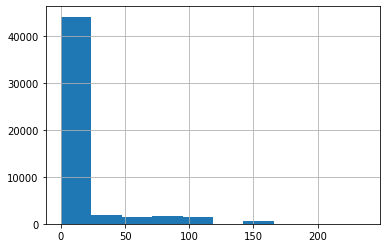

In [45]:
df_3.isna().sum(axis=1).hist()

In [46]:
df_3.isna().sum(axis=1).sort_values(ascending=False)

38941    237
8886     237
3558     236
36553    217
35014    217
        ... 
21805      0
21806      0
21807      0
21808      0
51123      0
Length: 51124, dtype: int64

In [47]:
ex = df_3.isna().sum(axis=1).to_frame()
ex = ex.rename({0:'values'}, axis=1)  # new method
ex

,values
0,1
1,0
2,0
3,0
4,0
...,...
51119,0
51120,0
51121,0
51122,32


In [48]:
helper_1 = ex.groupby('values').size().to_frame()
helper_1 = helper_1.rename({0:'values_f'}, axis=1)  # new method

In [49]:
helper_1.columns

Index(['values_f'], dtype='object')

In [50]:
helper_1['suma_acumulativa'] = helper_1['values_f'].cumsum()
helper_1

,values_f,suma_acumulativa
values,,
0,31262,31262
1,12365,43627
2,481,44108
20,1,44109
21,1,44110
25,2,44112
26,1,44113
27,4,44117
28,94,44211


In [51]:
helper_1['precentil_acumulativo'] = round(100*helper_1['suma_acumulativa']/helper_1['values_f'].sum(),3)
helper_1

,values_f,suma_acumulativa,precentil_acumulativo
values,,,
0,31262,31262,61.149
1,12365,43627,85.336
2,481,44108,86.277
20,1,44109,86.278
21,1,44110,86.280
25,2,44112,86.284
26,1,44113,86.286
27,4,44117,86.294
28,94,44211,86.478


In [52]:
corrdat_target = df.corr()

In [53]:
corrdat_target['target'].sort_values(key=abs, ascending=False)

target          1.000000
FlgActCN_T02   -0.259991
FlgActCN_T03   -0.254062
FlgActCN_T01   -0.249027
FlgActCN_T04   -0.222971
                  ...   
ColL2T0_T07     0.000254
FlgActAI_T04    0.000120
FacCCOT_T02    -0.000059
Txs_T11         0.000022
CambioPin            NaN
Name: target, Length: 561, dtype: float64

In [54]:
corrdat_target['target'].sort_values(key=abs, ascending=False).head(100)

target           1.000000
FlgActCN_T02    -0.259991
FlgActCN_T03    -0.254062
FlgActCN_T01    -0.249027
FlgActCN_T04    -0.222971
                   ...   
Fac_T05         -0.095903
FacDebAtm_T04   -0.095038
Col_T09          0.093247
TxsDebAtm_T08   -0.092785
TxsDebCom_T01   -0.092454
Name: target, Length: 100, dtype: float64

In [55]:
lim = 0.1
corr_value_target = getCorr(corrdat_target['target'], lim)

Internauta
ColL1TE_T09
EeccNac_T09
UsoL1_T09
Col_T08
ColL1TE_T08
EeccNac_T08
UsoL1_T08
Col_T07
ColL1TE_T07
EeccNac_T07
UsoL1_T07
FlgAct_T06
FlgActCN_T06
FlgActCCPC_T06
Txs_T06
FacCN_T06
TxsCN_T06
TxsDebAtm_T06
Col_T06
ColL1TE_T06
EeccNac_T06
UsoL1_T06
FlgAct_T05
FlgActCN_T05
FlgActCCPC_T05
Txs_T05
FacCN_T05
TxsCN_T05
TxsCCPC_T05
TxsDebAtm_T05
Col_T05
ColL1TE_T05
EeccNac_T05
UsoL1_T05
FlgAct_T04
FlgActCN_T04
FlgActCCPC_T04
Fac_T04
Txs_T04
FacCN_T04
TxsCN_T04
TxsCCPC_T04
TxsDebAtm_T04
Col_T04
ColL1TE_T04
ColL2T0_T04
EeccNac_T04
UsoL1_T04
FlgAct_T03
FlgActCN_T03
FlgActCCPC_T03
Fac_T03
Txs_T03
FacCN_T03
TxsCN_T03
TxsCCPC_T03
TxsDebAtm_T03
Col_T03
ColL1TE_T03
ColL2T0_T03
EeccNac_T03
UsoL1_T03
FlgAct_T02
FlgActCN_T02
FlgActCCPC_T02
Fac_T02
Txs_T02
FacCN_T02
TxsCN_T02
TxsCCPC_T02
TxsDebAtm_T02
ColL1TE_T02
ColL2T0_T02
EeccNac_T02
UsoL1_T02
FlgAct_T01
FlgActCN_T01
FlgActCCPC_T01
Fac_T01
Txs_T01
FacCN_T01
TxsCN_T01
TxsCCPC_T01
TxsDebAtm_T01
ColL1TE_T01
ColL2T0_T01
EeccNac_T01
UsoL1_T01
target


In [58]:
corr_value_target.shape

(90, 1)

In [64]:
ex[ex.values >= 2].index

Int64Index([   12,    15,    34,    39,    43,    46,    58,    71,    77,
               91,
            ...
            51020, 51025, 51050, 51051, 51063, 51074, 51086, 51098, 51112,
            51122],
           dtype='int64', length=7497)

In [79]:
df_4 = df_3.drop(ex[ex.values >= 2].index)

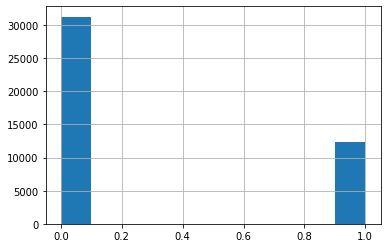

In [80]:
df_4.isna().sum(axis=1).hist()

In [85]:
enc = OneHotEncoder()

In [89]:
data_encoder = enc.fit_transform(df_4[['Sexo']])

In [91]:
dat = data_encoder.toarray()

In [94]:
dat

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [95]:
df_enc = pd.DataFrame(dat, columns=['h', 'm'])

In [96]:
df_enc

,h,m
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
43622,0.0,1.0
43623,1.0,0.0
43624,1.0,0.0
43625,1.0,0.0


In [104]:
df_5 = df_4.reset_index()
df_5 = df_5.join(df_enc)
df_5 = df_5.drop(columns=['index', 'Sexo'])
df_5

,Subsegmento,Region,Renta,Internauta,Adicional,Dualidad,Hipotecario,Cuentas,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAI_T11,TxsAI_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,TxsDebCom_T11,FacDebAtm_T11,TxsDebAtm_T11,ColL1TE_T11,ColL2T0_T11,ColMx_T11,PagoNac_T11,PagoInt_T11,EeccNac_T11,EeccInt_T11,UsoL1_T11,UsoLI_T11,...,ColL1T0_T02,ColL1TE_T02,ColL2T0_T02,ColL2CC_T02,ColMx_T02,PagoNac_T02,PagoInt_T02,EeccNac_T02,EeccInt_T02,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsPAT_T01,TxsCCPC_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,UsoL1_T01,UsoLI_T01,IndRev_T01,target,h,m
0,160,13.0,NaN,1,1,0,0,1,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,122000.0,4.0,676433.0,17260.0,0.0,0.0,0.0,739270.0,0.0,739270.0,0.0,...,0.0,1019435.0,0.0,43696.0,0.0,33000.0,0.0,1072040.0,0.0,1072040.00,29396.0,0.0,R,0,0,0,0,0,0,0,0,0,0,0,0,1069735.0,0,1040339.0,0,29396,0.0,33000,0.0,1099866.0,1099866.0,0.0,R,0.0,0.0,1.0
1,160,13.0,143640.0,1,0,0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,291725.0,8.0,0.0,0.0,0.0,0.0,237115.0,5.0,9640.0,1.0,0.0,0.0,0.0,95003.0,366706.0,0.0,150000.0,0.0,356576.0,0.0,356576.0,0.0,...,0.0,441135.0,4764.0,0.0,0.0,14000.0,0.0,462736.0,0.0,462736.00,9529.0,0.0,R,1,1,0,1,0,1,118247,1,0,0,0,1,211884.0,0,162939.0,48945,0,0.0,300000,0.0,214592.0,214592.0,0.0,R,0.0,1.0,0.0
2,170,13.0,929106.0,1,1,0,1,1,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,689000.0,17.0,0.0,0.0,0.0,178179.0,0.0,0.0,0.0,14850.0,0.0,...,48279.0,0.0,0.0,0.0,0.0,25189.0,0.0,0.0,0.0,32740.00,0.0,0.0,T,1,1,0,0,0,3,191336,3,0,0,0,0,7400.0,7400,0.0,0,0,0.0,216676,0.0,0.0,7400.0,0.0,T,0.0,1.0,0.0
3,151,13.0,172447.0,0,1,0,0,1,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,72416.0,4.0,0.0,0.0,0.0,0.0,53032.0,2.0,0.0,0.0,0.0,0.0,0.0,309221.0,13994.0,0.0,50000.0,0.0,347432.0,0.0,347432.0,0.0,...,0.0,275320.0,23169.0,3249.0,0.0,60000.0,0.0,303400.0,0.0,303400.00,16813.0,0.0,R,1,1,0,1,0,1,11890,1,0,0,0,1,262160.0,0,244048.0,18112,0,0.0,60000,0.0,272762.0,272762.0,0.0,R,0.0,1.0,0.0
4,170,13.0,805250.0,0,1,1,1,2,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,526687.0,12.0,0.0,0.0,0.0,0.0,424064.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,176786.0,0.0,245513.0,0.0,225748.0,0.0,101864.0,0.0,...,58706.0,0.0,183400.0,42704.0,0.0,143686.0,0.0,184685.0,0.0,93302.00,453873.0,0.0,T,1,1,0,1,1,10,173576,10,0,0,0,3,306161.0,60008,0.0,214125,32028,0.0,272925,0.0,249562.0,75339.0,0.0,R,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43622,160,13.0,414316.0,1,0,1,0,2,1020000,440000.0,1600.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,476000.0,14.0,0.0,0.0,0.0,160310.0,0.0,48309.0,0.0,0.0,0.0,...,7000.0,300.0,109004.0,0.0,0.0,48801.0,0.0,73377.0,0.0,76877.00,147209.0,0.0,R,1,0,1,0,0,1,0,0,0,0,1,0,129962.0,2901,0.0,87161,39900,0.0,153096,0.0,76219.0,2901.0,0.0,T,0.0,0.0,1.0
43623,160,13.0,364978.0,1,1,1,0,2,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,71470.0,8.0,0.0,0.0,0.0,0.0,55610.0,5.0,0.0,0.0,0.0,684000.0,8.0,443366.0,35117.0,0.0,75000.0,0.0,529384.0,0.0,543642.0,0.0,...,24728.0,607072.0,23698.0,0.0,0.0,50000.0,0.0,679172.0,0.0,679172.00,32468.0,0.0,R,1,1,0,0,0,5,62808,5,0,0,0,0,463255.0,62808,379646.0,20801,0,0.0,300000,0.0,478320.0,478320.0,0.0,R,0.0,1.0,0.0
43624,170,13.0,625376.0,1,0,0,0,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,56666.0,1.0,0.0,0.0,0.0,0.

In [112]:
le = LabelEncoder()
df_5.IndRev_T01 = le.fit_transform(df_5.IndRev_T01)
df_5.IndRev_T02 = le.fit_transform(df_5.IndRev_T02)
df_5.IndRev_T03 = le.fit_transform(df_5.IndRev_T03)
df_5.IndRev_T04 = le.fit_transform(df_5.IndRev_T04)
df_5.IndRev_T05 = le.fit_transform(df_5.IndRev_T05)
df_5.IndRev_T06 = le.fit_transform(df_5.IndRev_T06)
df_5.IndRev_T07 = le.fit_transform(df_5.IndRev_T07)
df_5.IndRev_T08 = le.fit_transform(df_5.IndRev_T08)
df_5.IndRev_T09 = le.fit_transform(df_5.IndRev_T09)
df_5.IndRev_T10 = le.fit_transform(df_5.IndRev_T10)
df_5.IndRev_T11 = le.fit_transform(df_5.IndRev_T11)

In [113]:
df_5

,Subsegmento,Region,Renta,Internauta,Adicional,Dualidad,Hipotecario,Cuentas,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAI_T11,TxsAI_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,TxsDebCom_T11,FacDebAtm_T11,TxsDebAtm_T11,ColL1TE_T11,ColL2T0_T11,ColMx_T11,PagoNac_T11,PagoInt_T11,EeccNac_T11,EeccInt_T11,UsoL1_T11,UsoLI_T11,...,ColL1T0_T02,ColL1TE_T02,ColL2T0_T02,ColL2CC_T02,ColMx_T02,PagoNac_T02,PagoInt_T02,EeccNac_T02,EeccInt_T02,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsPAT_T01,TxsCCPC_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,UsoL1_T01,UsoLI_T01,IndRev_T01,target,h,m
0,160,13.0,NaN,1,1,0,0,1,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,122000.0,4.0,676433.0,17260.0,0.0,0.0,0.0,739270.0,0.0,739270.0,0.0,...,0.0,1019435.0,0.0,43696.0,0.0,33000.0,0.0,1072040.0,0.0,1072040.00,29396.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1069735.0,0,1040339.0,0,29396,0.0,33000,0.0,1099866.0,1099866.0,0.0,1,0.0,0.0,1.0
1,160,13.0,143640.0,1,0,0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,291725.0,8.0,0.0,0.0,0.0,0.0,237115.0,5.0,9640.0,1.0,0.0,0.0,0.0,95003.0,366706.0,0.0,150000.0,0.0,356576.0,0.0,356576.0,0.0,...,0.0,441135.0,4764.0,0.0,0.0,14000.0,0.0,462736.0,0.0,462736.00,9529.0,0.0,1,1,1,0,1,0,1,118247,1,0,0,0,1,211884.0,0,162939.0,48945,0,0.0,300000,0.0,214592.0,214592.0,0.0,1,0.0,1.0,0.0
2,170,13.0,929106.0,1,1,0,1,1,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,689000.0,17.0,0.0,0.0,0.0,178179.0,0.0,0.0,0.0,14850.0,0.0,...,48279.0,0.0,0.0,0.0,0.0,25189.0,0.0,0.0,0.0,32740.00,0.0,0.0,2,1,1,0,0,0,3,191336,3,0,0,0,0,7400.0,7400,0.0,0,0,0.0,216676,0.0,0.0,7400.0,0.0,2,0.0,1.0,0.0
3,151,13.0,172447.0,0,1,0,0,1,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,72416.0,4.0,0.0,0.0,0.0,0.0,53032.0,2.0,0.0,0.0,0.0,0.0,0.0,309221.0,13994.0,0.0,50000.0,0.0,347432.0,0.0,347432.0,0.0,...,0.0,275320.0,23169.0,3249.0,0.0,60000.0,0.0,303400.0,0.0,303400.00,16813.0,0.0,1,1,1,0,1,0,1,11890,1,0,0,0,1,262160.0,0,244048.0,18112,0,0.0,60000,0.0,272762.0,272762.0,0.0,1,0.0,1.0,0.0
4,170,13.0,805250.0,0,1,1,1,2,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,526687.0,12.0,0.0,0.0,0.0,0.0,424064.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,176786.0,0.0,245513.0,0.0,225748.0,0.0,101864.0,0.0,...,58706.0,0.0,183400.0,42704.0,0.0,143686.0,0.0,184685.0,0.0,93302.00,453873.0,0.0,2,1,1,0,1,1,10,173576,10,0,0,0,3,306161.0,60008,0.0,214125,32028,0.0,272925,0.0,249562.0,75339.0,0.0,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43622,160,13.0,414316.0,1,0,1,0,2,1020000,440000.0,1600.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,476000.0,14.0,0.0,0.0,0.0,160310.0,0.0,48309.0,0.0,0.0,0.0,...,7000.0,300.0,109004.0,0.0,0.0,48801.0,0.0,73377.0,0.0,76877.00,147209.0,0.0,1,1,0,1,0,0,1,0,0,0,0,1,0,129962.0,2901,0.0,87161,39900,0.0,153096,0.0,76219.0,2901.0,0.0,2,0.0,0.0,1.0
43623,160,13.0,364978.0,1,1,1,0,2,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,71470.0,8.0,0.0,0.0,0.0,0.0,55610.0,5.0,0.0,0.0,0.0,684000.0,8.0,443366.0,35117.0,0.0,75000.0,0.0,529384.0,0.0,543642.0,0.0,...,24728.0,607072.0,23698.0,0.0,0.0,50000.0,0.0,679172.0,0.0,679172.00,32468.0,0.0,1,1,1,0,0,0,5,62808,5,0,0,0,0,463255.0,62808,379646.0,20801,0,0.0,300000,0.0,478320.0,478320.0,0.0,1,0.0,1.0,0.0
43624,170,13.0,625376.0,1,0,0,0,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,56666.0,1.0,0.0,0.0,0.0,0.

In [114]:
knn_imputer = KNNImputer(n_neighbors=4, weights="uniform")
knn_imputer.fit_transform(df_5)
knn_imputer

KNNImputer(n_neighbors=4)

In [117]:
df_6 = df_5.copy()

In [119]:
columnas_df_6 = []
for i in df_6.columns:
    columnas_df_6.append(i)

In [125]:
df_5.isna().sum()

Subsegmento        0
Region            27
Renta          11111
Internauta         0
Adicional          0
               ...  
UsoLI_T01          0
IndRev_T01         0
target          1227
h                  0
m                  0
Length: 300, dtype: int64

In [142]:
df_5.dropna(subset = ["target"], inplace=True)

In [144]:
df_5

,Subsegmento,Region,Renta,Internauta,Adicional,Dualidad,Hipotecario,Cuentas,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAI_T11,TxsAI_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,TxsDebCom_T11,FacDebAtm_T11,TxsDebAtm_T11,ColL1TE_T11,ColL2T0_T11,ColMx_T11,PagoNac_T11,PagoInt_T11,EeccNac_T11,EeccInt_T11,UsoL1_T11,UsoLI_T11,...,ColL1T0_T02,ColL1TE_T02,ColL2T0_T02,ColL2CC_T02,ColMx_T02,PagoNac_T02,PagoInt_T02,EeccNac_T02,EeccInt_T02,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsPAT_T01,TxsCCPC_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,UsoL1_T01,UsoLI_T01,IndRev_T01,target,h,m
0,160,13.0,NaN,1,1,0,0,1,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,122000.0,4.0,676433.0,17260.0,0.0,0.0,0.0,739270.0,0.0,739270.0,0.0,...,0.0,1019435.0,0.0,43696.0,0.0,33000.0,0.0,1072040.0,0.0,1072040.00,29396.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1069735.0,0,1040339.0,0,29396,0.0,33000,0.0,1099866.0,1099866.0,0.0,1,0.0,0.0,1.0
1,160,13.0,143640.0,1,0,0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,291725.0,8.0,0.0,0.0,0.0,0.0,237115.0,5.0,9640.0,1.0,0.0,0.0,0.0,95003.0,366706.0,0.0,150000.0,0.0,356576.0,0.0,356576.0,0.0,...,0.0,441135.0,4764.0,0.0,0.0,14000.0,0.0,462736.0,0.0,462736.00,9529.0,0.0,1,1,1,0,1,0,1,118247,1,0,0,0,1,211884.0,0,162939.0,48945,0,0.0,300000,0.0,214592.0,214592.0,0.0,1,0.0,1.0,0.0
2,170,13.0,929106.0,1,1,0,1,1,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,689000.0,17.0,0.0,0.0,0.0,178179.0,0.0,0.0,0.0,14850.0,0.0,...,48279.0,0.0,0.0,0.0,0.0,25189.0,0.0,0.0,0.0,32740.00,0.0,0.0,2,1,1,0,0,0,3,191336,3,0,0,0,0,7400.0,7400,0.0,0,0,0.0,216676,0.0,0.0,7400.0,0.0,2,0.0,1.0,0.0
3,151,13.0,172447.0,0,1,0,0,1,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,72416.0,4.0,0.0,0.0,0.0,0.0,53032.0,2.0,0.0,0.0,0.0,0.0,0.0,309221.0,13994.0,0.0,50000.0,0.0,347432.0,0.0,347432.0,0.0,...,0.0,275320.0,23169.0,3249.0,0.0,60000.0,0.0,303400.0,0.0,303400.00,16813.0,0.0,1,1,1,0,1,0,1,11890,1,0,0,0,1,262160.0,0,244048.0,18112,0,0.0,60000,0.0,272762.0,272762.0,0.0,1,0.0,1.0,0.0
4,170,13.0,805250.0,0,1,1,1,2,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,526687.0,12.0,0.0,0.0,0.0,0.0,424064.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,176786.0,0.0,245513.0,0.0,225748.0,0.0,101864.0,0.0,...,58706.0,0.0,183400.0,42704.0,0.0,143686.0,0.0,184685.0,0.0,93302.00,453873.0,0.0,2,1,1,0,1,1,10,173576,10,0,0,0,3,306161.0,60008,0.0,214125,32028,0.0,272925,0.0,249562.0,75339.0,0.0,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43622,160,13.0,414316.0,1,0,1,0,2,1020000,440000.0,1600.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,476000.0,14.0,0.0,0.0,0.0,160310.0,0.0,48309.0,0.0,0.0,0.0,...,7000.0,300.0,109004.0,0.0,0.0,48801.0,0.0,73377.0,0.0,76877.00,147209.0,0.0,1,1,0,1,0,0,1,0,0,0,0,1,0,129962.0,2901,0.0,87161,39900,0.0,153096,0.0,76219.0,2901.0,0.0,2,0.0,0.0,1.0
43623,160,13.0,364978.0,1,1,1,0,2,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,71470.0,8.0,0.0,0.0,0.0,0.0,55610.0,5.0,0.0,0.0,0.0,684000.0,8.0,443366.0,35117.0,0.0,75000.0,0.0,529384.0,0.0,543642.0,0.0,...,24728.0,607072.0,23698.0,0.0,0.0,50000.0,0.0,679172.0,0.0,679172.00,32468.0,0.0,1,1,1,0,0,0,5,62808,5,0,0,0,0,463255.0,62808,379646.0,20801,0,0.0,300000,0.0,478320.0,478320.0,0.0,1,0.0,1.0,0.0
43624,170,13.0,625376.0,1,0,0,0,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,56666.0,1.0,0.0,0.0,0.0,0.

In [145]:
helper_2 = df_5.isna().sum().to_frame()
helper_2 = helper_2.rename({0:'value'}, axis=1)

In [146]:
helper_2[helper_2.value > 0]

,value
Region,27
Renta,11111


In [147]:
df_6 = df_5.copy()
knn_imputer_2 = KNNImputer(n_neighbors=4, weights="uniform")
df_6[['Region', 'Renta']] = knn_imputer_2.fit_transform(df_6[['Region', 'Renta']])


In [152]:
df_6.isna().sum()

Subsegmento    0
Region         0
Renta          0
Internauta     0
Adicional      0
              ..
UsoLI_T01      0
IndRev_T01     0
target         0
h              0
m              0
Length: 300, dtype: int64

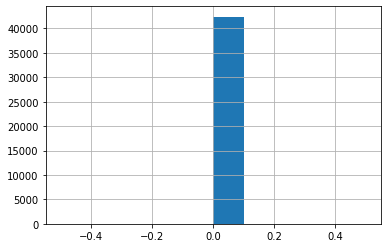

In [153]:
df_6.isna().sum(axis=1).hist()

In [154]:
Q1 = df_6.quantile(0.25)
Q3 = df_6.quantile(0.75)
IQR = Q3 - Q1
((df_6 < (Q1 - 1.5 * IQR)) | (df_6 > (Q3 + 1.5 * IQR))).sum()

Subsegmento       36
Region          1617
Renta           2228
Internauta         0
Adicional          0
               ...  
UsoLI_T01       3371
IndRev_T01     11199
target           270
h                  0
m                  0
Length: 300, dtype: int64

In [157]:
helper_3 = ((df_6 < (Q1 - 1.5 * IQR)) | (df_6 > (Q3 + 1.5 * IQR))).sum().to_frame()
helper_3 = helper_3.rename({0:'value'}, axis=1)

In [162]:
helper_3.sort_values(by='value', ascending=False)


,value
IndRev_T11,15072
IndRev_T10,14009
IndRev_T09,13652
IndRev_T08,12835
IndRev_T06,12358
...,...
FlgAct_T05,0
FlgActCCPC_T01,0
FlgActCCPC_T06,0
FlgActCN_T06,0


In [163]:
print(df_6.shape)

(42400, 300)


In [164]:
scaler = MinMaxScaler()
scaler.fit(df_6)
array_scaler = scaler.transform(df_6)

In [167]:
df_7 = pd.DataFrame(array_scaler)
df_7.columns = df_6.columns
df_7.describe()

,Subsegmento,Region,Renta,Internauta,Adicional,Dualidad,Hipotecario,Cuentas,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAI_T11,TxsAI_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,TxsDebCom_T11,FacDebAtm_T11,TxsDebAtm_T11,ColL1TE_T11,ColL2T0_T11,ColMx_T11,PagoNac_T11,PagoInt_T11,EeccNac_T11,EeccInt_T11,UsoL1_T11,UsoLI_T11,...,ColL1T0_T02,ColL1TE_T02,ColL2T0_T02,ColL2CC_T02,ColMx_T02,PagoNac_T02,PagoInt_T02,EeccNac_T02,EeccInt_T02,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsPAT_T01,TxsCCPC_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,UsoL1_T01,UsoLI_T01,IndRev_T01,target,h,m
count,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.00000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,...,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000,42400.000000
mean,0.044744,0.822840,0.048721,0.675189,0.274552,0.368679,0.148703,0.099741,0.057212,0.028597,0.037544,0.683939,0.603561,0.036226,0.002311,0.14375,0.293349,0.102264,0.385593,0.075601,0.001400,0.002529,0.000473,0.000625,0.008764,0.016711,0.001468,0.014418,0.023501,0.016015,0.039117,0.022114,0.013842,0.001425,0.008493,0.000632,0.494963,0.209054,0.494679,0.209168,...,0.008429,0.029136,0.016280,0.013720,0.003144,0.021167,0.000375,0.333316,0.526058,0.362406,0.012019,0.626275,0.565071,0.662618,0.569646,0.150967,0.274151,0.095637,0.059597,0.061011,0.054367,0.001268,0.002180,0.023403,0.022495,0.026482,0.009681,0.029289,0.008487,0.014951,0.002630,0.009158,0.000407,0.324360,0.478464,0.665299,0.550413,0.000032,0.536675,0.463325
std,0.042793,0.279999,0.028141,0.468310,0.446293,0.482452,0.355799,0.139403,0.052268,0.064119,0.042073,0.464943,0.489163,0.186855,0.048021,0.35084,0.455302,0.302999,0.019970,0.062789,0.015688,0.021438,0.013838,0.016072,0.027089,0.037395,0.014601,0.048798,0.046902,0.026250,0.053891,0.055128,0.032865,0.014437,0.019686,0.012088,0.027101,0.011463,0.026799,0.011755,...,0.021516,0.063177,0.037129,0.034649,0.027321,0.037816,0.008916,0.046666,0.010666,0.044264,0.037458,0.011883,0.253654,0.472822,0.495131,0.358021,0.446091,0.294096,0.048437,0.040788,0.046105,0.013120,0.017183,0.069396,0.051928,0.045518,0.024464,0.063133,0.021349,0.037853,0.024223,0.017660,0.009293,0.047435,0.036591,0.009458,0.251976,0.004860,0.498659,0.498659
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [182]:
X = df_7.drop(['target'], axis=1)
Y = df_7.target.copy()

In [198]:
train_size = 0.80
test_size = 1 - train_size
random_state = 40
CV = 10
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, random_state=random_state)
metricas = []

#### lineal


In [199]:
reg_lineal = linear_model.LinearRegression()
reg_lineal.fit(X_train, Y_train)
y_predicted_linear = reg_lineal.predict(X_test)
reg_lineal.score(X_test,Y_test)

-7.3374188631084

In [200]:
#print('Coefficients: \n', 'Intercepto: ',reg_lineal.intercept_, '\nLos demas parametros betas:',reg_lineal.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, y_predicted_linear))
print('Mean absolute error: %.2f'
      % mean_absolute_error(Y_test, y_predicted_linear))
print('Coefficient of determination: %.2f'
      % r2_score(Y_test, y_predicted_linear))
metricas.append(["Lineal",train_size, test_size,CV,mean_squared_error(Y_test, y_predicted_linear),mean_absolute_error(Y_test, y_predicted_linear),r2_score(Y_test, y_predicted_linear)])

Mean squared error: 0.00
Mean absolute error: 0.00
Coefficient of determination: -7.34


#### Lasso


In [201]:
alpha = 0.01
reg_lasso = linear_model.Lasso(alpha=alpha)
reg_lasso.fit(X_train, Y_train)
y_predicted_lasso = reg_lasso.predict(X_test)

In [202]:
#print('Coefficients: \n', 'Intercepto: ',reg_lasso.intercept_, '\nLos demas parametros betas:',reg_lasso.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, y_predicted_lasso))
print('Mean absolute error: %.2f'
      % mean_absolute_error(Y_test, y_predicted_lasso))
print('Coefficient of determination: %.2f'
      % r2_score(Y_test, y_predicted_lasso))
metricas.append(["Lasso",train_size, test_size,CV, alpha,mean_squared_error(Y_test, y_predicted_lasso),mean_absolute_error(Y_test, y_predicted_lasso),r2_score(Y_test, y_predicted_lasso)])

Mean squared error: 0.00
Mean absolute error: 0.00
Coefficient of determination: -0.09


#### arbol


In [203]:
max_depth = 10
reg_tree = DecisionTreeRegressor(max_depth=max_depth)
reg_tree.fit(X_train, Y_train)
y_predicted_tree = reg_tree.predict(X_test)

In [204]:
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, y_predicted_tree))
print('Mean absolute error: %.2f'
      % mean_absolute_error(Y_test, y_predicted_tree))
print('Coefficient of determination: %.2f'
      % r2_score(Y_test, y_predicted_tree))
metricas.append(["Arbol",train_size, test_size,CV,max_depth,mean_squared_error(Y_test, y_predicted_tree),mean_absolute_error(Y_test, y_predicted_tree),r2_score(Y_test, y_predicted_tree)])

Mean squared error: 0.00
Mean absolute error: 0.00
Coefficient of determination: -2.84


### Visual

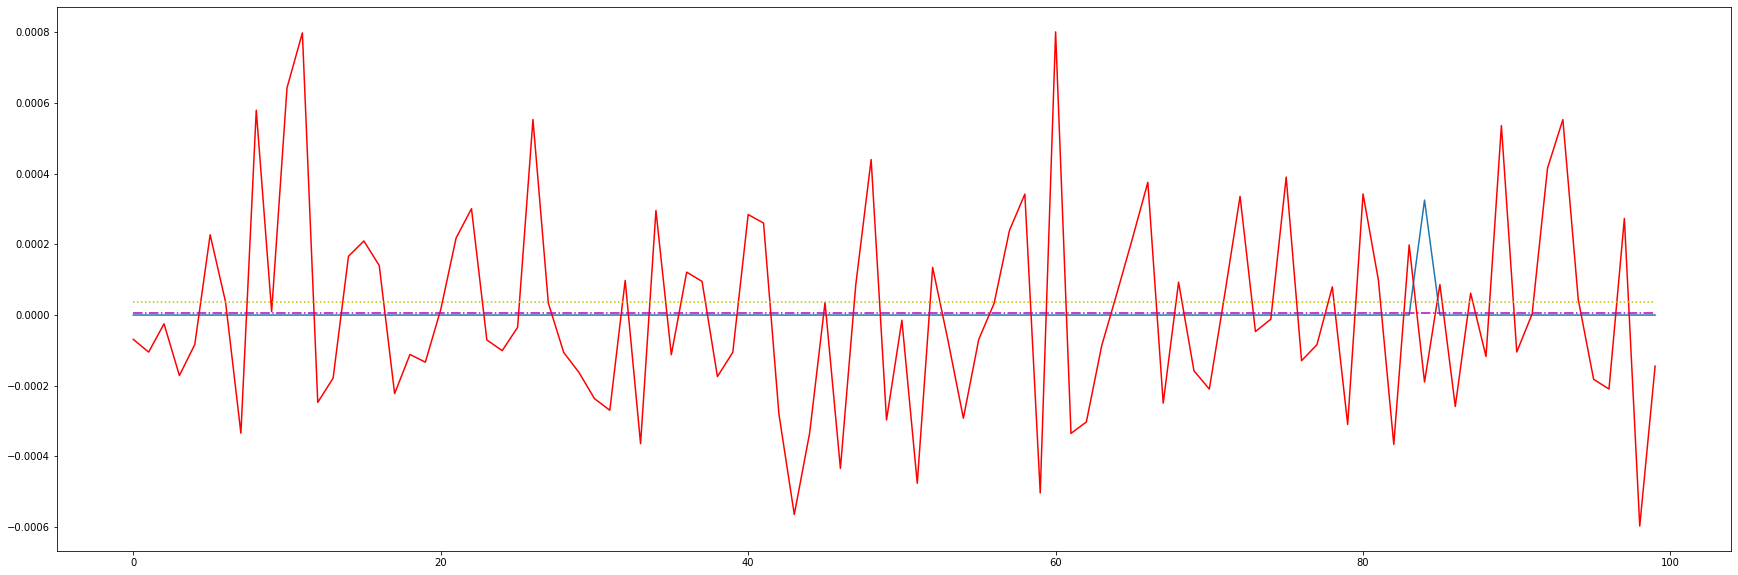

In [205]:
plt.subplots(figsize=(30,10))

plt.plot(np.array(Y_test[:100]).reshape(-1,1))
plt.plot(np.array(y_predicted_linear[:100]).reshape(-1,1), 'r-')
plt.plot(np.array(y_predicted_lasso[:100]).reshape(-1,1), 'y:')
plt.plot(np.array(y_predicted_tree[:100]).reshape(-1,1), 'm-.')

plt.show()

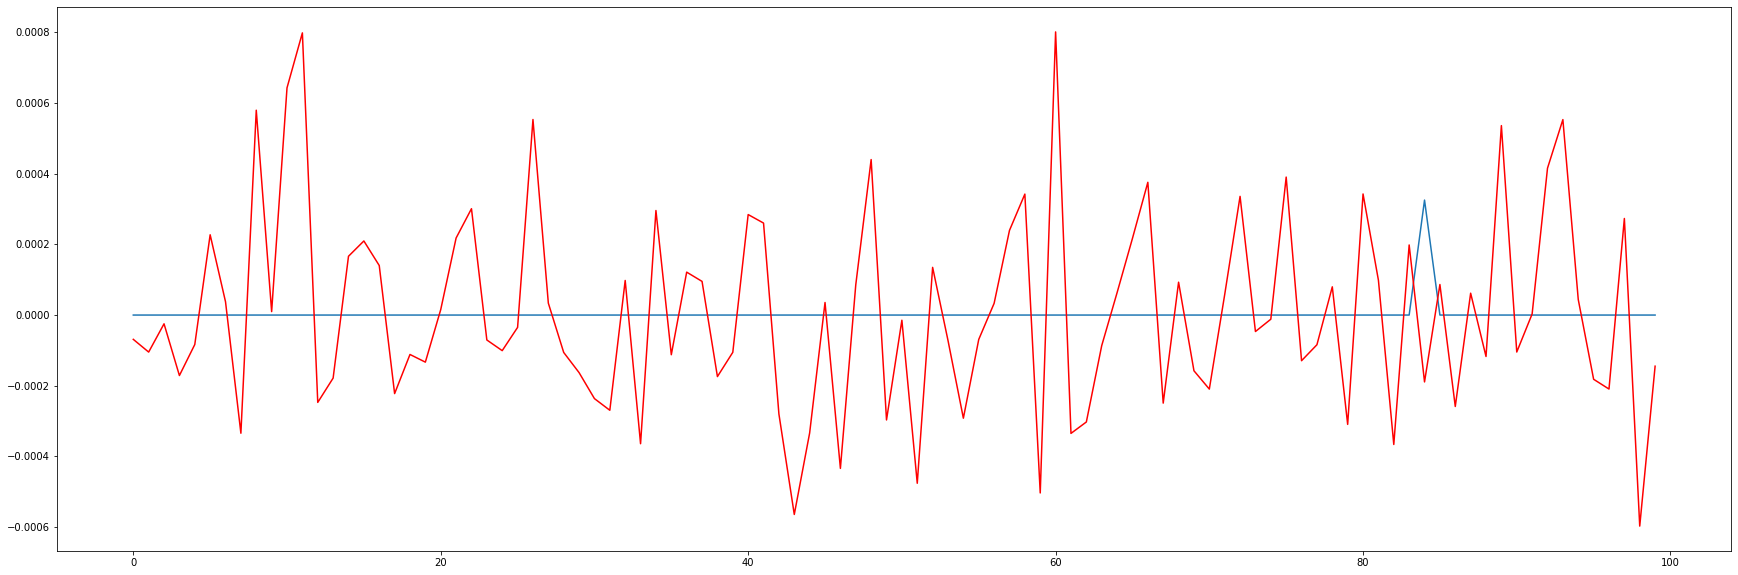

In [206]:
plt.subplots(figsize=(30,10))

plt.plot(np.array(Y_test[:100]).reshape(-1,1))
plt.plot(np.array(y_predicted_linear[:100]).reshape(-1,1), 'r-')


plt.show()